In [6]:
import torch
from pyperlin import FractalPerlin2D
import matplotlib.pyplot as plt
import noise
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import matplotlib.pyplot as plt
import porespy as ps
import numpy as np
import inspect
inspect.signature(ps.generators.fractal_noise)

<Signature (shape, frequency=0.05, octaves=4, gain=0.5, mode='simplex', seed=None, cores=None, uniform=True)>

(-0.5, 99.5, -0.5, 99.5)

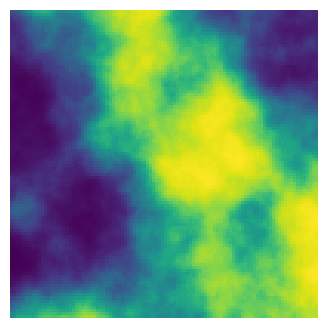

In [26]:
np.random.seed(10)
shape = [100, 100]
im = ps.generators.fractal_noise(shape=shape, octaves = 10, frequency=0.01)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(im, origin='lower', interpolation='none')
ax.axis(False)

In [5]:


fig, ax = plt.subplots(2, 2, figsize=[8, 8])

mode='perlin'
uniform=True
im1 = ps.generators.fractal_noise(shape=shape, gain=gain, seed=seed, cores=cores, mode=mode, uniform=uniform)
ax[0][0].imshow(im1)
ax[0][0].axis(False)
ax[0][0].set_title(f'uniform = {uniform}')

uniform=False
im2 = ps.generators.fractal_noise(shape=shape, gain=gain, seed=seed, cores=cores, mode=mode, uniform=uniform)
ax[0][1].imshow(im2)
ax[0][1].axis(False)
ax[0][1].set_title(f'uniform = {uniform}')

ax[1][0].hist(im1.flatten())
ax[1][1].hist(im2.flatten());

ImportError: cannot import name 'marching_cubes_lewiner' from 'skimage.measure' (/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/skimage/measure/__init__.py)

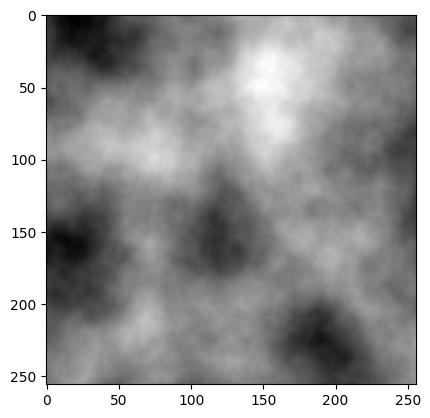

In [7]:

shape = (32,256,256) #for batch size = 32 and noises' shape = (256,256)
resolutions = [(2**i,2**i) for i in range(1,7)] #for lacunarity = 2.0
factors = [.5**i for i in range(6)] #for persistence = 0.5
g_cuda = torch.Generator(device='mps') #for GPU acceleration
fp = FractalPerlin2D(shape, resolutions, factors, generator=g_cuda)
egnoise = fp() #sampling

plt.imshow(egnoise[0].cpu().numpy(), cmap='gray')

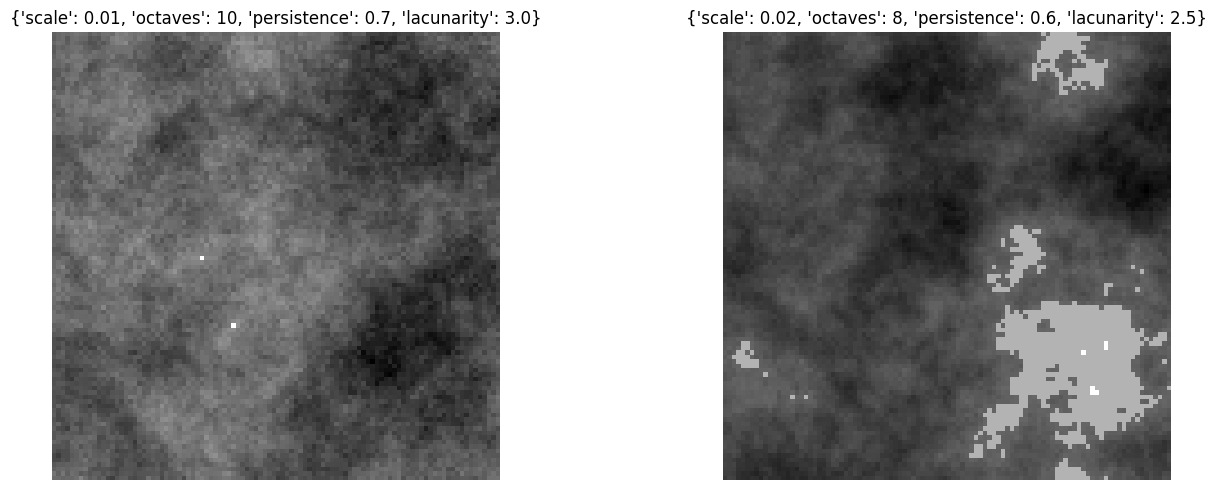

In [8]:
def generate_grid(width, height, scale=0.1, octaves=6, persistence=0.5, lacunarity=2.0):
    """Generate a 2D grid with obstacles using simplex noise."""
    
    # Create an empty grid
    grid = np.empty((height, width))
    
    # Populate the grid with noise values
    for x in range(width):
        for y in range(height):
            # Generate simplex noise
            n = noise.pnoise2(x*scale, y*scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
            
            # Convert noise value to [0, 1]
            n = (n + 1) / 2
            
            # Create a halo effect for larger clusters
            if n > 0.7:
                n = 1
            elif n > 0.6:
                n = 0.8
                
            grid[y, x] = n
    
    return grid

# Define different parameter combinations
params = [
    {"scale": 0.01, "octaves": 10, "persistence": 0.7, "lacunarity": 3.0},  # More fractal-like
    {"scale": 0.02, "octaves": 8, "persistence": 0.6, "lacunarity": 2.5},  # More fractal-like
    # {"scale": 0.1, "octaves": 6, "persistence": 0.5, "lacunarity": 2.0}, too small
    # {"scale": 0.05, "octaves": 3, "persistence": 0.4, "lacunarity": 1.5}, a bit bigger
    # Add more parameter combinations as desired
]

fig, axes = plt.subplots(nrows=1, ncols=len(params), figsize=(15, 5))

# For each parameter set, generate and visualize the grid
for i, p in enumerate(params):
    grid = generate_grid(100, 100, **p)
    axes[i].imshow(grid, cmap="gray")
    axes[i].set_title(str(p))
    axes[i].axis("off")

plt.tight_layout()
plt.show()


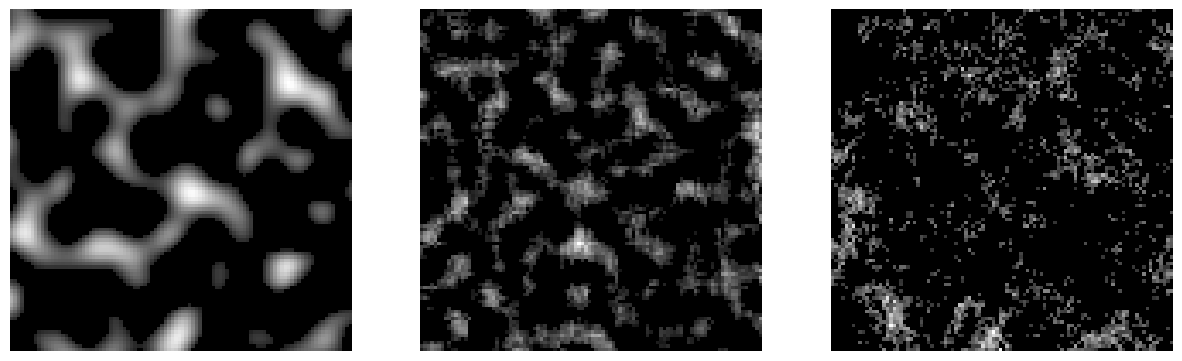

In [9]:
import random
config = {
    "environment": {
        "obstacle_generation": "perlin_noise",
        "obstacle_generation_params": {
            "empty_threshold": [0.05, 0.1],
            "full_threshold": [0.8, 0.9],
            "frequency": [4.0, 30.0],
            "octaves": [1, 10],
            "persistence": [0.2, 1.0],
            "lacunarity": [1.5, 4.0]
        }
    }
}
def populate_obstacle(config, channel):
    obstacle_params = config["environment"]["obstacle_generation_params"]
    
    if config["environment"]["obstacle_generation"] == "perlin_noise":
        empty_threshold = obstacle_params.get("empty_threshold", [0.05, 0.1])
        full_threshold = obstacle_params.get("full_threshold", [0.8, 0.9])
        frequency_range = obstacle_params.get("frequency", [4.0, 16.0])
        octaves_range = obstacle_params.get("octaves", [1, 4])
        persistence_range = obstacle_params.get("persistence", [0.25, 1.0])
        lacunarity_range = obstacle_params.get("lacunarity", [1.5, 3.0])

        empty_threshold = random.uniform(*empty_threshold)
        full_threshold = random.uniform(*full_threshold)
        frequency = random.uniform(*frequency_range)
        octaves = random.randint(*octaves_range)
        persistence = random.uniform(*persistence_range)
        lacunarity = random.uniform(*lacunarity_range)

        # Generate random offsets for x and y
        x_offset = random.randint(0, 10000)
        y_offset = random.randint(0, 10000)

        for x in range(channel.shape[0]):
            for y in range(channel.shape[1]):
                value = noise.pnoise2((x + x_offset) / frequency, (y + y_offset) / frequency, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
                channel[x, y] = 1 if value > full_threshold else 0 if value < empty_threshold else value
    else:
        raise ValueError(f"Obstacle generation method {config['environment']['obstacle_generation']} not recognized.")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# visualize 4 random obstacle maps
for i in range(3):
    channel = np.zeros((100, 100))
    populate_obstacle(config, channel)
    axes[i].imshow(channel, cmap="gray")
    axes[i].axis("off")

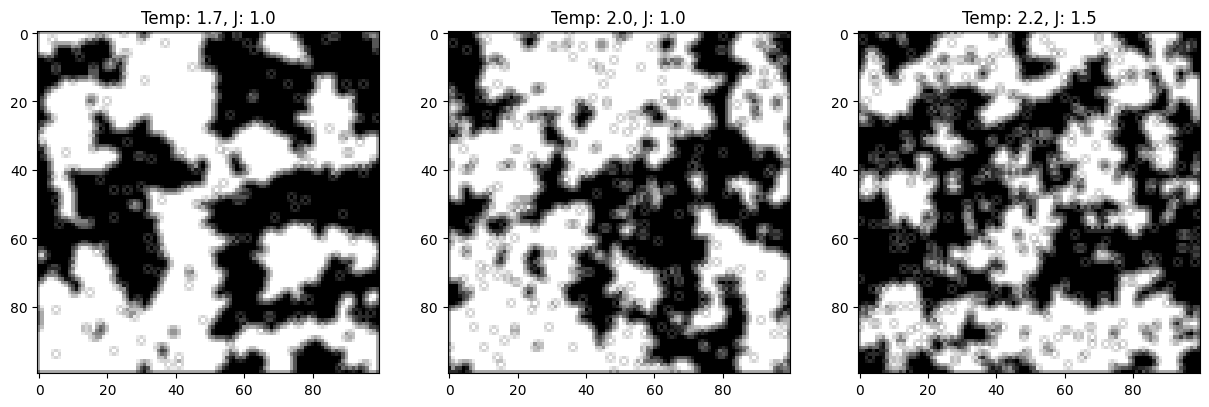

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_obstacles(width, height, noise_params=None):
    if noise_params is None:
        noise_params = {'temp': 2.26, 'j': 1.0}  # Default values for 2D Ising

    # Create a random matrix
    lattice = torch.randint(2, (width, height), dtype=torch.float32) * 2 - 1

    # Ising model update (Metropolis algorithm for a few iterations)
    for _ in range(10):
        for x in range(width):
            for y in range(height):
                deltaE = 2 * lattice[x, y] * (lattice[(x+1) % width, y] + lattice[x-1, y] + lattice[x, (y+1) % height] + lattice[x, y-1])
                if deltaE < 0 or torch.rand(1) < torch.exp(-deltaE / noise_params['temp']):
                    lattice[x, y] *= -1

    # Normalize to [0, 1]
    lattice = (lattice + 1) / 2

    # Apply filter for boundaries
    filter_kernel = torch.tensor([[0.5, 1, 0.5], [1, 0, 1], [0.5, 1, 0.5]])
    lattice = torch.nn.functional.conv2d(lattice.unsqueeze(0).unsqueeze(0), filter_kernel.unsqueeze(0).unsqueeze(0), padding=1).squeeze()

    return lattice.numpy()

# Test Cases
param_sets = [
    {'temp': 1.7, 'j': 1.0},
    {'temp': 2.0, 'j': 1.0},
    {'temp': 2.2, 'j': 1.5},
]

fig, axes = plt.subplots(1, len(param_sets), figsize=(15, 5))

for ax, params in zip(axes, param_sets):
    obstacles = generate_obstacles(100, 100, noise_params=params)
    ax.imshow(obstacles, cmap="gray")
    ax.set_title(f"Temp: {params['temp']}, J: {params['j']}")

plt.show()


/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


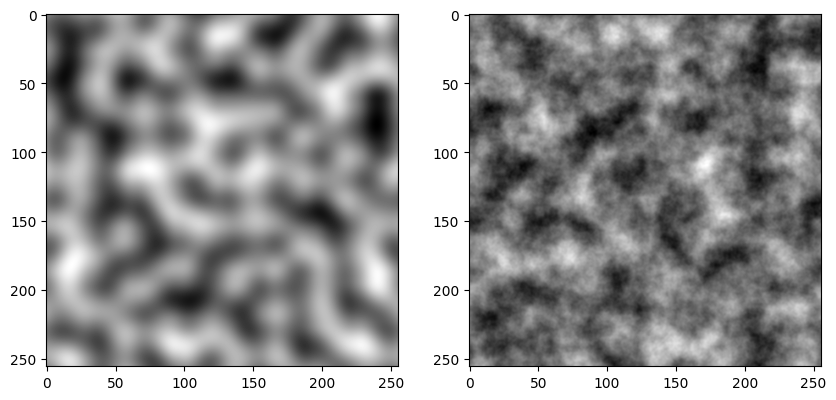

In [11]:
# ported from https://github.com/pvigier/perlin-numpy/blob/master/perlin2d.py

import torch
import math

def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

def rand_perlin_2d_octaves(shape, res, octaves=1, persistence=0.5):
    noise = torch.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * rand_perlin_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise

import matplotlib.pyplot as plt
    
fig, axs = plt.subplots(1,2, figsize=(10, 10))
noise = rand_perlin_2d((256, 256), (8, 8))
axs[0].imshow(noise, cmap='gray', interpolation='lanczos')

noise = rand_perlin_2d_octaves((256, 256), (8, 8), 5)
axs[1].imshow(noise, cmap='gray', interpolation='lanczos')
plt.show()

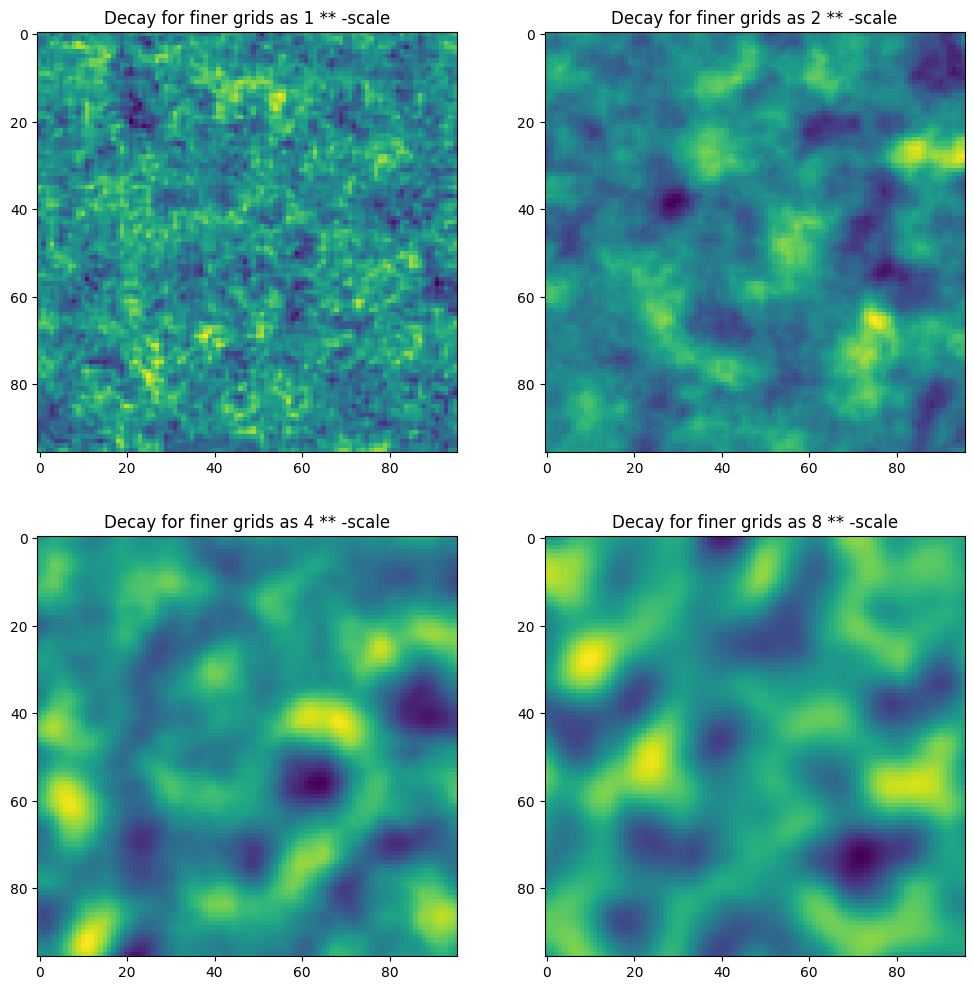

In [1]:
import torch as th
from matplotlib import pyplot as plt

def interp(t):
    return 3 * t**2 - 2 * t ** 3

def perlin(width, height, scale=10, device=None):
    gx, gy = th.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = th.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = th.linspace(0, 1, scale + 1)[None, :-1].to(device)


    wx = 1 - interp(xs)
    wy = 1 - interp(ys)

    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))

    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)

def perlin_ms(octaves=[1, 1, 1, 1], width=2, height=2, device=None):
    scale = 2 ** len(octaves)
    out = 0
    for oct in octaves:
        p = perlin(width, height, scale, device)
        out += p * oct
        scale //= 2
        width *= 2
        height *= 2
    return out


plt.figure(figsize=(12,12))
for idx, rho in enumerate([1, 2, 4, 8]):
    plt.subplot(2, 2, idx + 1)
    out = perlin_ms([rho**-i for i in range(4)], 6, 6).cpu().numpy()
    plt.imshow(out)
    plt.title(f"Decay for finer grids as {rho} ** -scale")

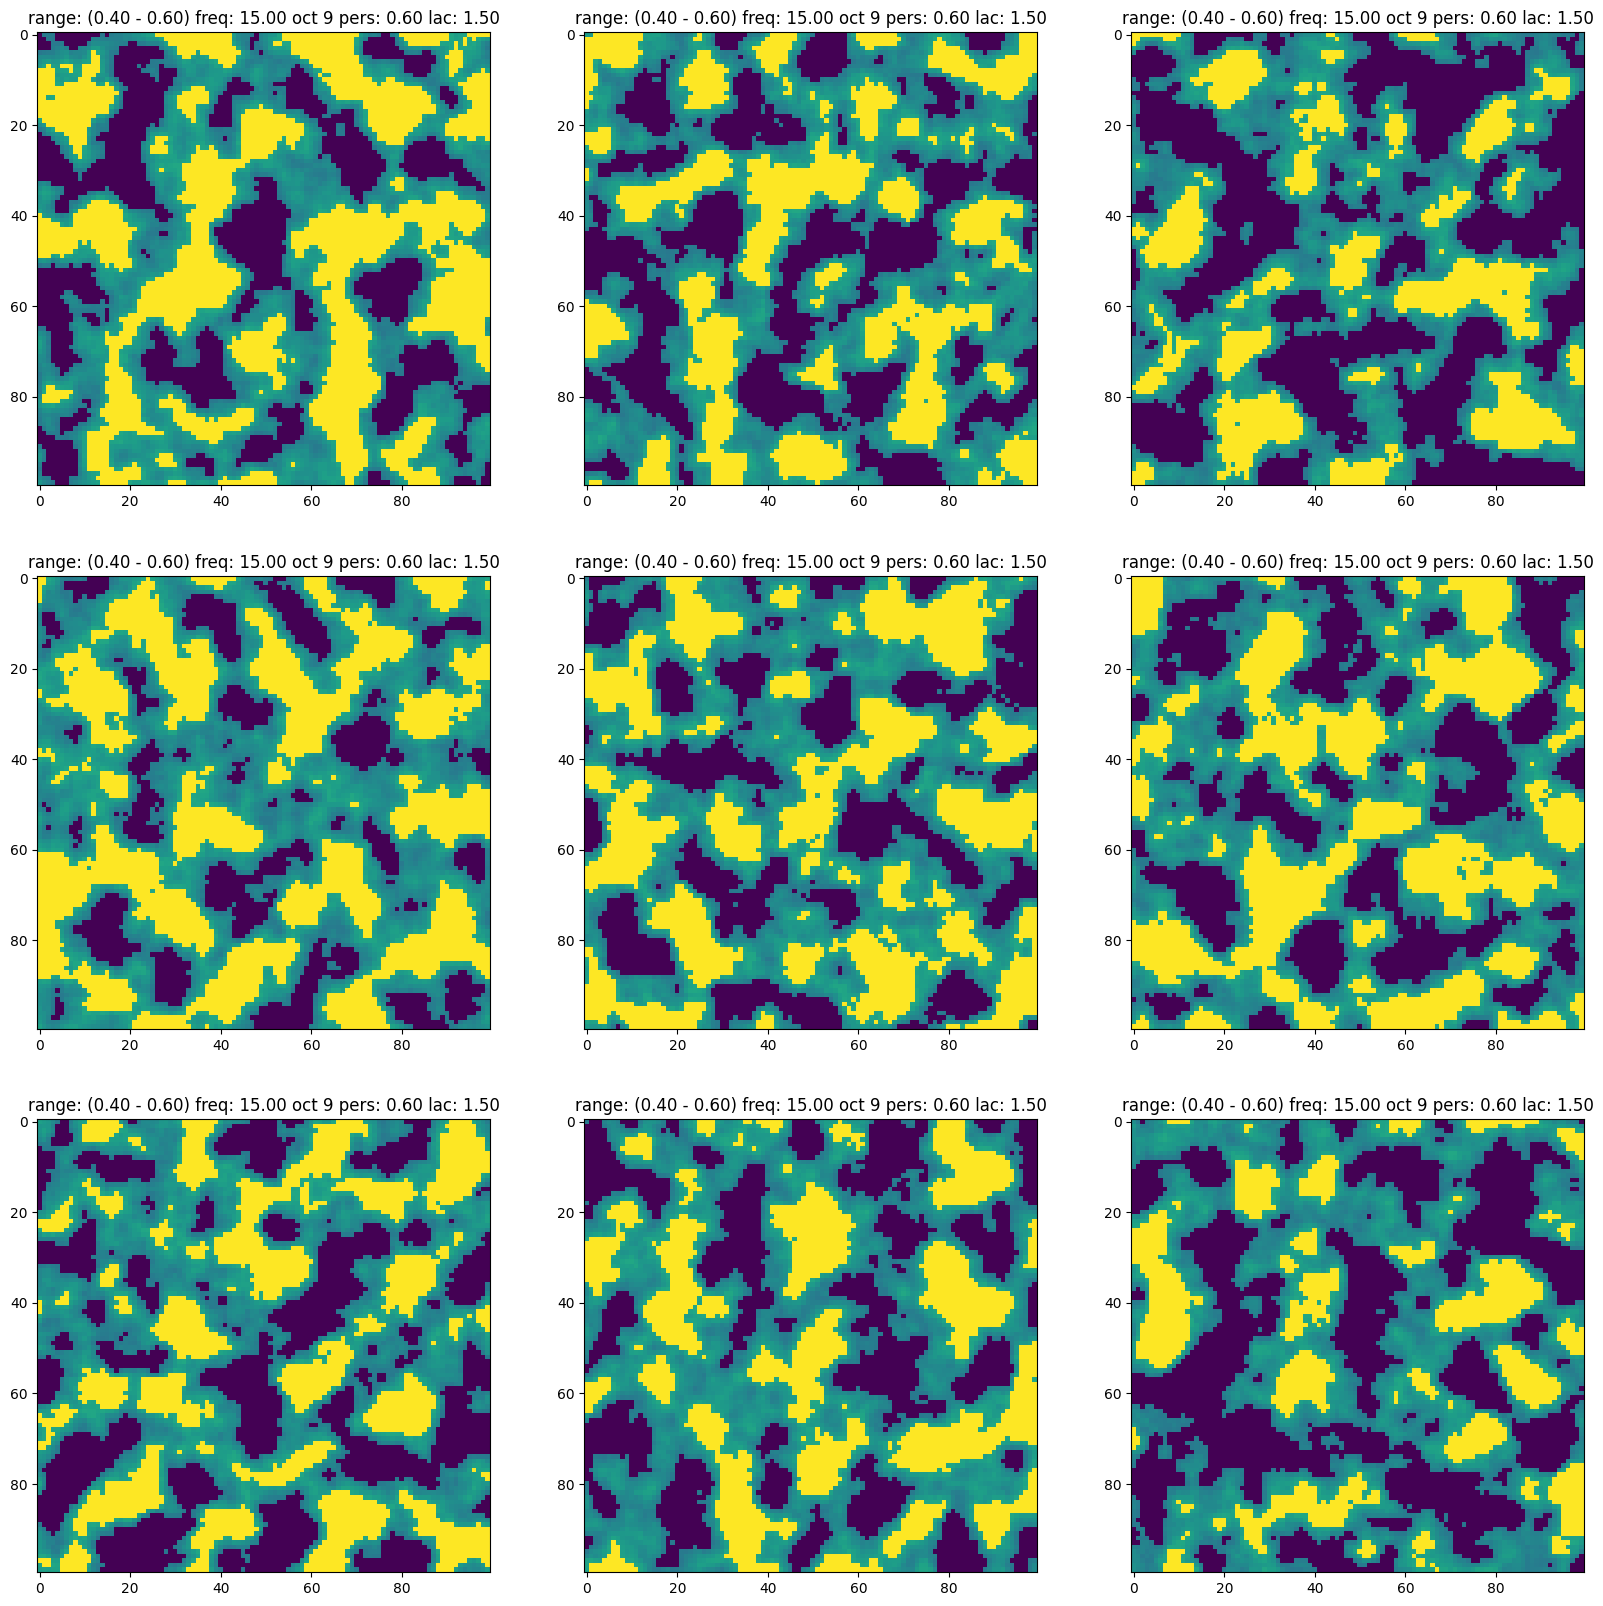

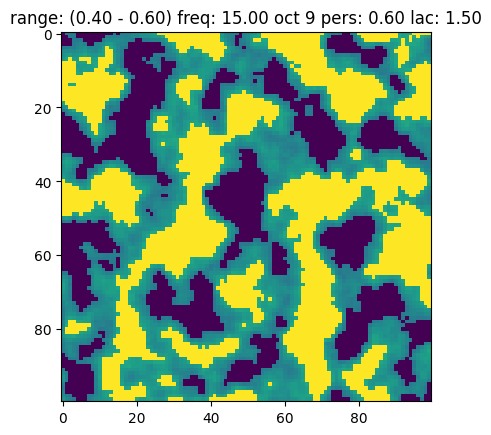

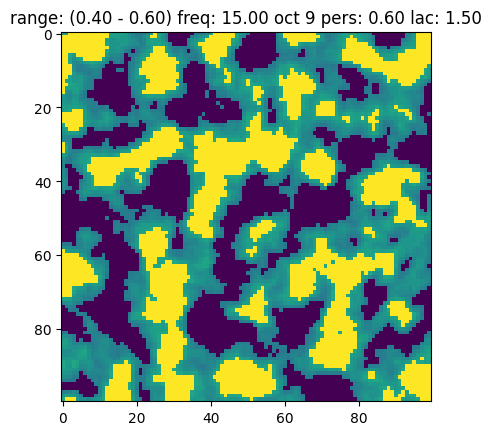

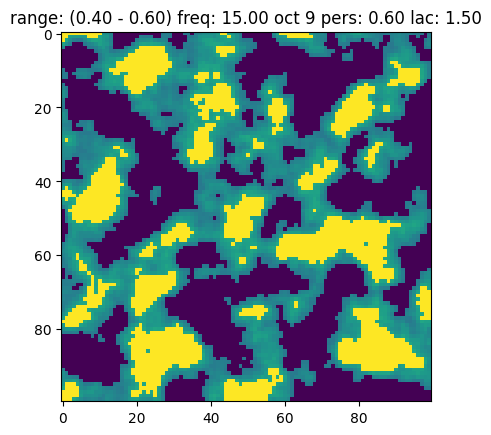

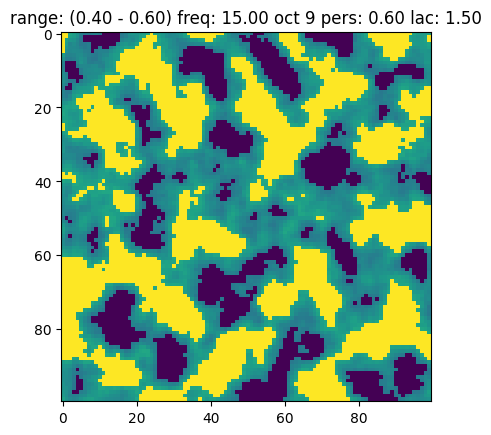

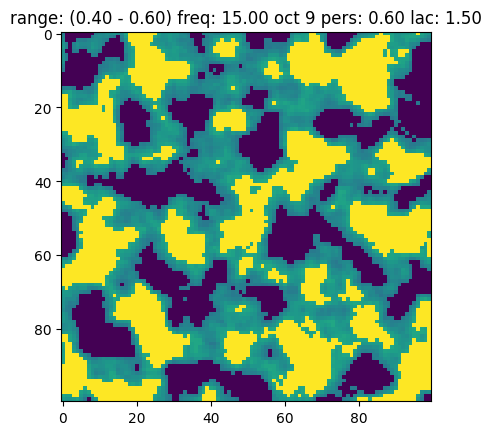

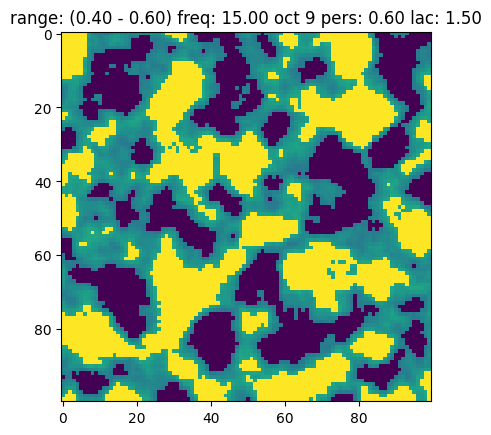

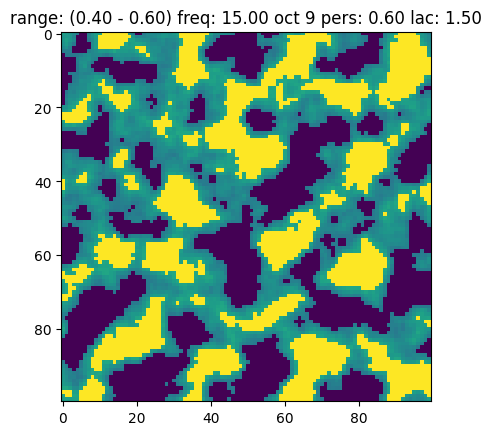

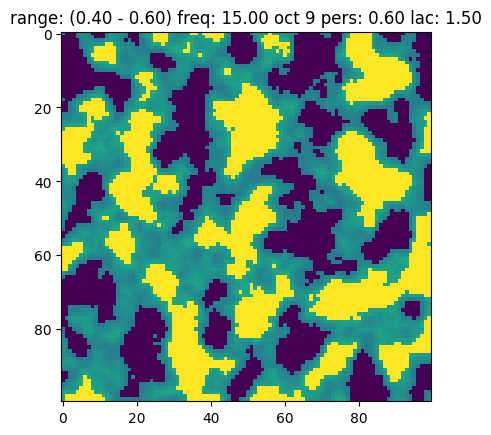

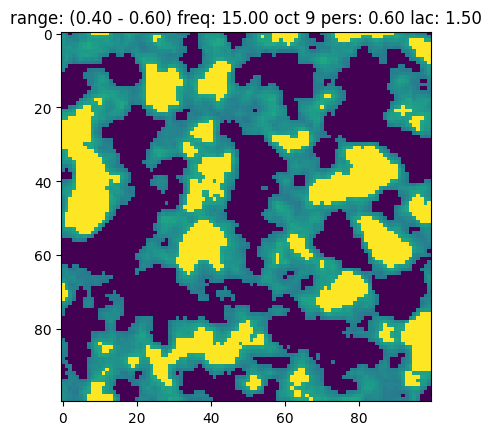

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import noise
import torch

def perlin2d(width, height, frequency=10.0, octaves=4, persistence=0.6,
                       lacunarity=3.0, x_offset=0, y_offset=0, channel=None, normalized=True):
    if channel is None:
        channel = torch.zeros((width, height))
    
    for x in range(width):
        for y in range(height):
            value = noise.pnoise2((x + x_offset) / frequency, (y + y_offset) / frequency, octaves=octaves, persistence=persistence, lacunarity=lacunarity)
            channel[x,y] = value
    
    if normalized:
        channel = (channel - channel.min()) / (channel.max() - channel.min())

    return channel

def gen_ob():
    shape = (100, 100)
    empty_threshold = 0.4#random.uniform(0.3, 0.4)
    full_threshold = 0.6#random.uniform(0.6, 0.7)
    frequency = 15#random.uniform(4.0, 30.0)
    octaves = 9#random.randint(, 10)
    persistence = 0.6#random.uniform(0.2, 1.0)
    lacunarity = 1.5#random.uniform(1.5, 4.0)

    x_offset = random.randint(0, 10000)
    y_offset = random.randint(0, 10000)

    obstacles = perlin2d(shape[0], shape[1], frequency, octaves, persistence,
                    lacunarity, x_offset, y_offset, normalized=True)
    obstacles = torch.where(obstacles > full_threshold, 1, obstacles)
    obstacles = np.where(obstacles < empty_threshold, 0, obstacles)


    fig, ax = plt.subplots()
    ax.imshow(obstacles)
    ax.set_title(f"range: ({empty_threshold:.2f} - {full_threshold:.2f}) " +
                f"freq: {frequency:.2f} oct {octaves} pers: {persistence:.2f} lac: {lacunarity:.2f}")
    return fig, ax

grid_fig, grid_ax = plt.subplots(3, 3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        fig, ax = gen_ob()
        grid_ax[i, j].imshow(ax.get_images()[0].get_array())
        grid_ax[i, j].set_title(ax.get_title())

plt.show()